In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('rec').getOrCreate()

In [2]:
books_rating_path = "book_recommendation/book_recommendation/BX-Book-Ratings.csv"
books_path = "book_recommendation/book_recommendation/BX-Books.csv"
books_user_path = "book_recommendation/book_recommendation/BX-Users.csv"

In [3]:
books = spark.read.format("csv") \
.option("inferSchema","true") \
.option("header","true") \
.option("mode","DROPMALFORMED") \
.option("delimiter", ";") \
.load(books_path)

users = spark.read.format("csv") \
.option("inferSchema","true") \
.option("header","true") \
.option("mode","DROPMALFORMED") \
.option("delimiter", ";") \
.load(books_user_path)

ratings = spark.read.format("csv") \
.option("inferSchema","true") \
.option("header","true") \
.option("mode","DROPMALFORMED") \
.option("delimiter", ";") \
.load(books_rating_path)

In [4]:
books.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: integer (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)



In [5]:
users.printSchema()

root
 |-- User-ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



In [6]:
ratings.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)



In [7]:
books = books.withColumnRenamed("ISBN","isbn") \
     .withColumnRenamed("Book-Title","book_title") \
     .withColumnRenamed('Book-Author','book_author') \

In [8]:
users = users.withColumnRenamed('User-ID','user_id')\
             .withColumnRenamed('Location','location')\
             .withColumnRenamed('Age','age')

In [9]:
ratings = ratings.withColumnRenamed('User-ID','user_id')\
                 .withColumnRenamed('ISBN','isbn')\
                 .withColumnRenamed('Book-Rating','book_rating')

In [10]:
ratings.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- book_rating: integer (nullable = true)



In [11]:
users.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- age: string (nullable = true)



In [12]:
books.printSchema()

root
 |-- isbn: string (nullable = true)
 |-- book_title: string (nullable = true)
 |-- book_author: string (nullable = true)
 |-- Year-Of-Publication: integer (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)



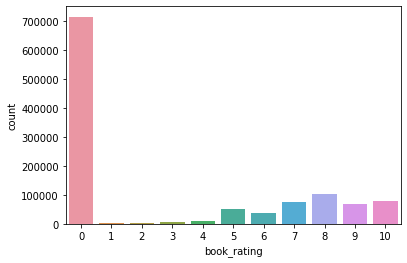

In [13]:
## lets visualize some key parameters 
import pyspark.sql.functions as F
import seaborn as sns 
temp_df = (ratings.groupBy('book_rating') 
                 .count()
                 .select('book_rating',F.col('count').cast('int'))
                 .toPandas()
                 .sort_values(by = 'count'))
sns.barplot(x = 'book_rating', y = 'count', data = temp_df)

### we can observe that most of the ratings are highly skewed with most of the ratings as null values which we want to predict

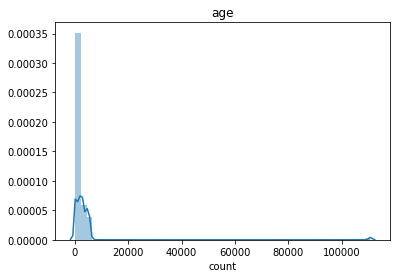

In [14]:
## now since we are going to recommend through age and location of the user makes sense to visualize it 

temp_df = (users.groupBy('age') 
                 .count()
                 .select('age',F.col('count').cast('int'))
                 .toPandas()
                 .sort_values(by = 'count'))
sns.distplot(temp_df['count'])
plt.title('age')
plt.show()

## so age is also extremely skewed as well as location

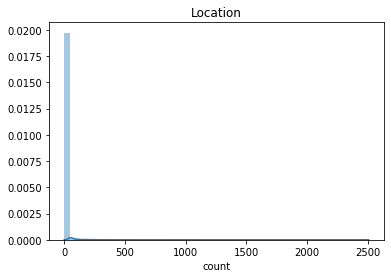

In [15]:
temp_df = (users.groupBy('location') 
                 .count()
                 .select('location',F.col('count').cast('int'))
                 .toPandas()
                 .sort_values(by = 'count'))
sns.distplot(temp_df['count'])
plt.title('Location')
plt.show()

In [16]:
## now we need to combine the tables in such a way that we have userID,ISBN of Book,Title of the book how many ratings are given 
## for these books all in one big table 

In [17]:
## lets use SQL to do this

In [18]:
ratings.createOrReplaceTempView('ratings')
books.createOrReplaceTempView('books')

In [19]:
combined_dataframe = spark.sql("""
             SELECT user_id,r.isbn,book_rating,book_title
             FROM ratings r INNER JOIN books b 
             ON r.isbn = b.isbn 
             """)

In [20]:
combined_dataframe.createOrReplaceTempView('combined_dataframe')

# we only take those books which have their total rating greater than 50
combined_and_filtered = spark.sql("""SELECT isbn,
                                            user_id,
                                            book_rating,
                                            book_title,
                                            sum(book_rating) OVER (PARTITION BY isbn) as total_book_rating, 
                                            count(user_id) OVER (PARTITION BY user_id) as user_ratings_total
                                    FROM combined_dataframe
                    
                    """).filter((F.col("total_book_rating") > 50) & (F.col('user_ratings_total') > 15))

In [21]:

location_filtered = users.filter(F.col("location").rlike(r"india|usa|china"))

In [22]:
combined_and_filtered.printSchema()

root
 |-- isbn: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- book_rating: integer (nullable = true)
 |-- book_title: string (nullable = true)
 |-- total_book_rating: long (nullable = true)
 |-- user_ratings_total: long (nullable = false)



In [23]:
filtered_with_location = location_filtered.join(combined_and_filtered, on = 'user_id', how = 'inner')\
                                           .select('user_id','isbn','book_rating','book_title')\
                                           .withColumn('user_id',F.col('user_id').cast('int'))

In [24]:
filtered_with_location.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- book_rating: integer (nullable = true)
 |-- book_title: string (nullable = true)



In [25]:
from pyspark.ml.recommendation import ALS 
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.feature import StringIndexer 

indexer = StringIndexer(inputCol = "isbn", outputCol = "isbn_indexed") 

indexed = indexer.fit(filtered_with_location).transform(filtered_with_location)\
                 .withColumn('isbn_indexed',F.col('isbn_indexed')\
                 .cast("int"))\
                 .drop('isbn')

indexed.printSchema()


training, test = indexed.randomSplit([0.8,0.1],)
training.count(),test.count()

root
 |-- user_id: integer (nullable = true)
 |-- book_rating: integer (nullable = true)
 |-- book_title: string (nullable = true)
 |-- isbn_indexed: integer (nullable = true)



(205553, 25488)

In [26]:
indexed.toPandas().to_json('recommnder.json')

In [27]:
indexed.sel

DataFrame[user_id: int, book_rating: int, book_title: string, isbn_indexed: int]

In [27]:
als = ALS(maxIter = 10 , 
          regParam = 0.9, 
          userCol = "user_id", 
          itemCol = "isbn_indexed", 
          ratingCol = "book_rating",
          nonnegative = True, 
          coldStartStrategy = 'drop')
model = als.fit(training)

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator 


predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName = 'rmse', labelCol = 'book_rating', predictionCol = "prediction")
rmse = evaluator.evaluate(predictions)
print("Root mean squared error:  ",rmse)

Root mean squared error:   3.5479597747510034


In [29]:
# so the rmse is the worst we will get so this tells us that our predictions have a variation of 6 i.e the ratings are off by 6

model

ALS_27c6ee3468d4

In [37]:
test.select('*').limit(10)

+-------+-----------+--------------------+------------+
|user_id|book_rating|          book_title|isbn_indexed|
+-------+-----------+--------------------+------------+
|  18979|          0|      Midnight Bayou|         430|
|  18979|          8|    Summer Pleasures|         420|
|  22521|          0|Dune Messiah (Dun...|        1284|
|  22521|         10|      Fahrenheit 451|          62|
|  23571|          0|All I Really Need...|          83|
|  23571|          0|Ghost Soldiers: T...|        4313|
|  23571|          0|It Was on Fire Wh...|         640|
|  23571|          0|   The Da Vinci Code|           2|
|  23571|          0|         Wild Animus|           0|
|  23571|          5|The Tenth Insight...|        1692|
+-------+-----------+--------------------+------------+



In [44]:
df = test.select(['user_id','book_rating','book_title','isbn_indexed'])

In [51]:
df.write.json("pyspark/testing_data_to_stream3.json")

In [118]:
als = ALS(maxIter = 10 ,
          userCol = "user_id", 
          itemCol = "isbn_indexed", 
          ratingCol = "book_rating",
          nonnegative = True, 
          coldStartStrategy = 'drop')

from pyspark.ml.tuning import ParamGridBuilder,CrossValidator 
grid = ParamGridBuilder().addGrid(als.rank, [10,30])\
                               .addGrid(als.regParam, [0.2,0.01,1,2])\
                               .build()

In [119]:

cv = CrossValidator(estimator = als,estimatorParamMaps = grid, evaluator = evaluator, parallelism = 4, numFolds = 3)

In [120]:
model = cv.fit(training)
best_model = model.bestModel

In [122]:
predictions = best_model.transform(test) 
rmse = evaluator.evaluate(predictions)
print("Root mean squared error:  ",rmse)

Root mean squared error:   3.5508231305680344


In [126]:
model.bestModel.rank

30

In [132]:
best_model

ALS_eefe6f1b05cd

In [135]:
test.filter(test['user_id'] == 11).show()

+-------+-----------+----------+------------+
|user_id|book_rating|book_title|isbn_indexed|
+-------+-----------+----------+------------+
+-------+-----------+----------+------------+



In [136]:
test.show()

+-------+-----------+--------------------+------------+
|user_id|book_rating|          book_title|isbn_indexed|
+-------+-----------+--------------------+------------+
|  18979|          0|The Macgregors: A...|        1709|
|  18979|          5|Hunting Badger (J...|        2417|
|  22521|          0|   A Wrinkle in Time|         332|
|  22521|          8|The Devil Wears P...|        2430|
|  23571|          0|Ghost Soldiers: T...|        4313|
|  23571|          0|Harry Potter and ...|         258|
|  23571|          0|The Best Democrac...|        4704|
|  23571|          7|            Catch 22|        1054|
|  23571|          8|         On the Road|        1057|
|  23571|          9|Bushwhacked : Lif...|        6299|
|  23571|         10|The Lion, the Wit...|        1139|
|  23571|         10|The Voyage of the...|        4480|
|  62680|          0|The Killing Game:...|         572|
|  67782|         10|A Shocker on Shoc...|        4601|
|  67782|         10|The Beast from th...|      

In [138]:
training.show()

+-------+-----------+--------------------+------------+
|user_id|book_rating|          book_title|isbn_indexed|
+-------+-----------+--------------------+------------+
|  18979|          0|         Divine Evil|        1651|
|  18979|          0|Irish Rebel (Spec...|         697|
|  18979|          0|      Midnight Bayou|         430|
|  18979|          0|         Mortal Prey|         639|
|  18979|          0|She's Come Undone...|          42|
|  18979|          4|     Purity in Death|         526|
|  18979|          5|       Brazen Virtue|        1013|
|  18979|          5|       Carolina Moon|         189|
|  18979|          5|Waiting For Nick ...|        3619|
|  18979|          6|Sullivan's Woman ...|        1613|
|  18979|          7|      Lost and Found|        1975|
|  18979|          7|Night Shield (Int...|        1461|
|  18979|          7|         Sacred Sins|         813|
|  18979|          7|    Smoke in Mirrors|        2700|
|  18979|          7|          The Search|      